# ORB Homework - Helper Notebook

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import cv2
import math
import skimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from scipy import ndimage as ndi
from utils import apply_gaussian_2d
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

## Pipeline Overview

**ORB** pipeline is extremely well-known and is implemented in many packages available to you. Before we try to implement the detector ourselves, let's see how it looks in the readily-available OpenCV implementation. We first take the ORB feature detector and, independently for each image, detect reproducible and discriminative regions of interest. This is exactly the part of the pipeline which we will try to re-implement in this homework.

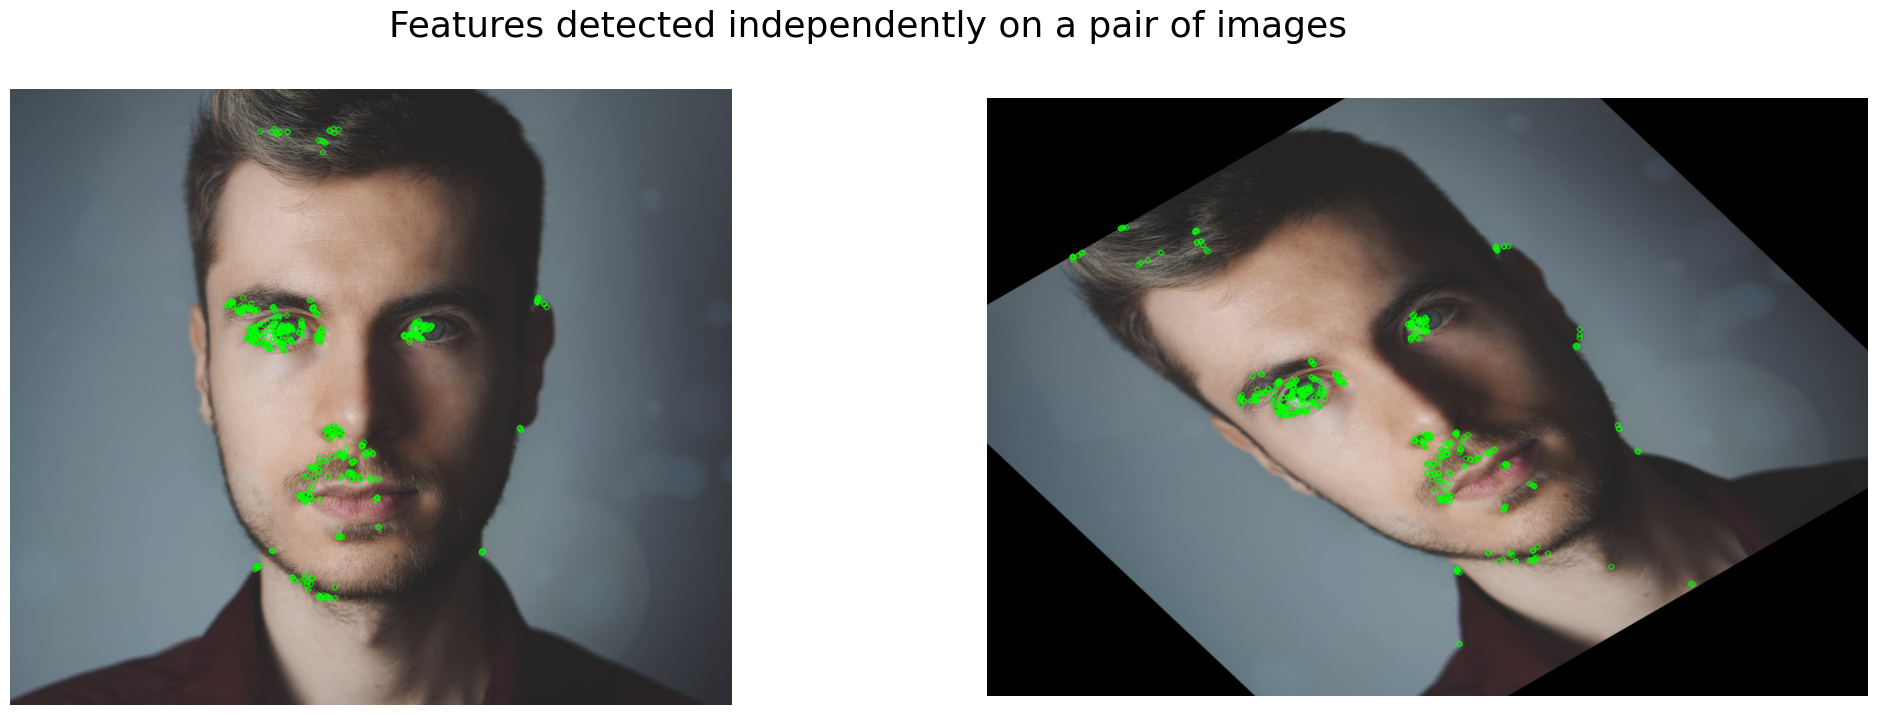

In [47]:
# Read the example image and create its transformed version to test correspondence mathcing
img1 = cv2.imread('img/face1.jpg')
M = np.array([[1, abs(0.3), 0],[0,1,0]])
nW =  img1.shape[1] + abs(0.3 * img1.shape[0])
img2 = cv2.warpAffine(img1, M, (int(nW), img1.shape[0]))
(h, w) = img2.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 30, 1.0)
img2 = cv2.warpAffine(img2, M, (w, h))

# Detect keypoints with ORB -> THIS IS THE PART WE WILL TRY TO RE-IMPLEMENT
orb_opencv = cv2.ORB_create()
kp1 = orb_opencv.detect(img1, None)
kp2 = orb_opencv.detect(img2, None)

# Visualize the results
img1kp = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0))
img2kp = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0))
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
axs[0].imshow(cv2.cvtColor(img1kp, cv2.COLOR_RGB2BGR))
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2kp, cv2.COLOR_RGB2BGR))
axs[1].axis("off")
fig.suptitle("Features detected independently on a pair of images", size=26);

Once we have the interest points for a pair of images, we can match and filter them to create a set of correspondences, which can be further used in different computer vision tasks.

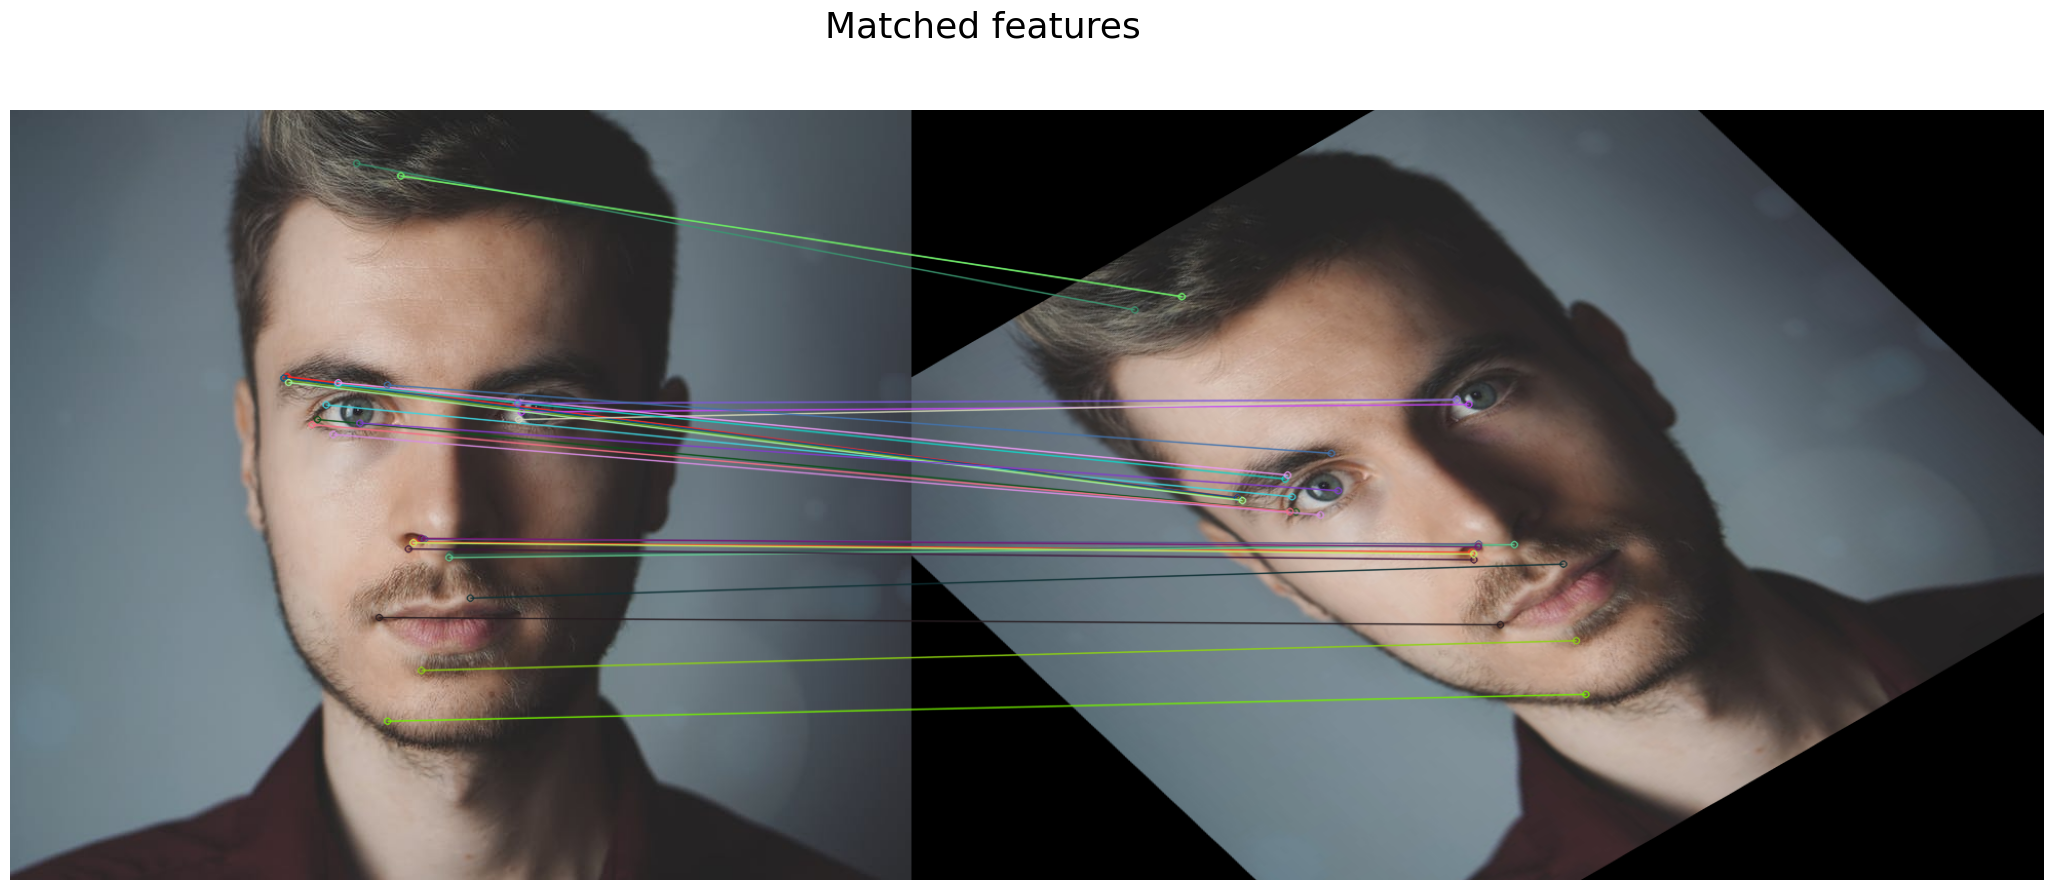

In [48]:
orb_opencv = cv2.ORB_create()
kp1, desc1 = orb_opencv.detectAndCompute(img1, None)
kp2, desc2 = orb_opencv.detectAndCompute(img2, None)
bf = cv2.BFMatcher()
matches = bf.match(desc1, desc2) 
matches = sorted(matches, key=lambda x:x.distance)
res = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(35, 10))
ax.imshow(cv2.cvtColor(res, cv2.COLOR_RGB2BGR))
ax.axis("off")
fig.suptitle("Matched features", size=26);

## Individual Functions Helpers

Below you will find the example outputs you should get for each functions so that you can compare your results to it.

### `get_first_test_mask()`


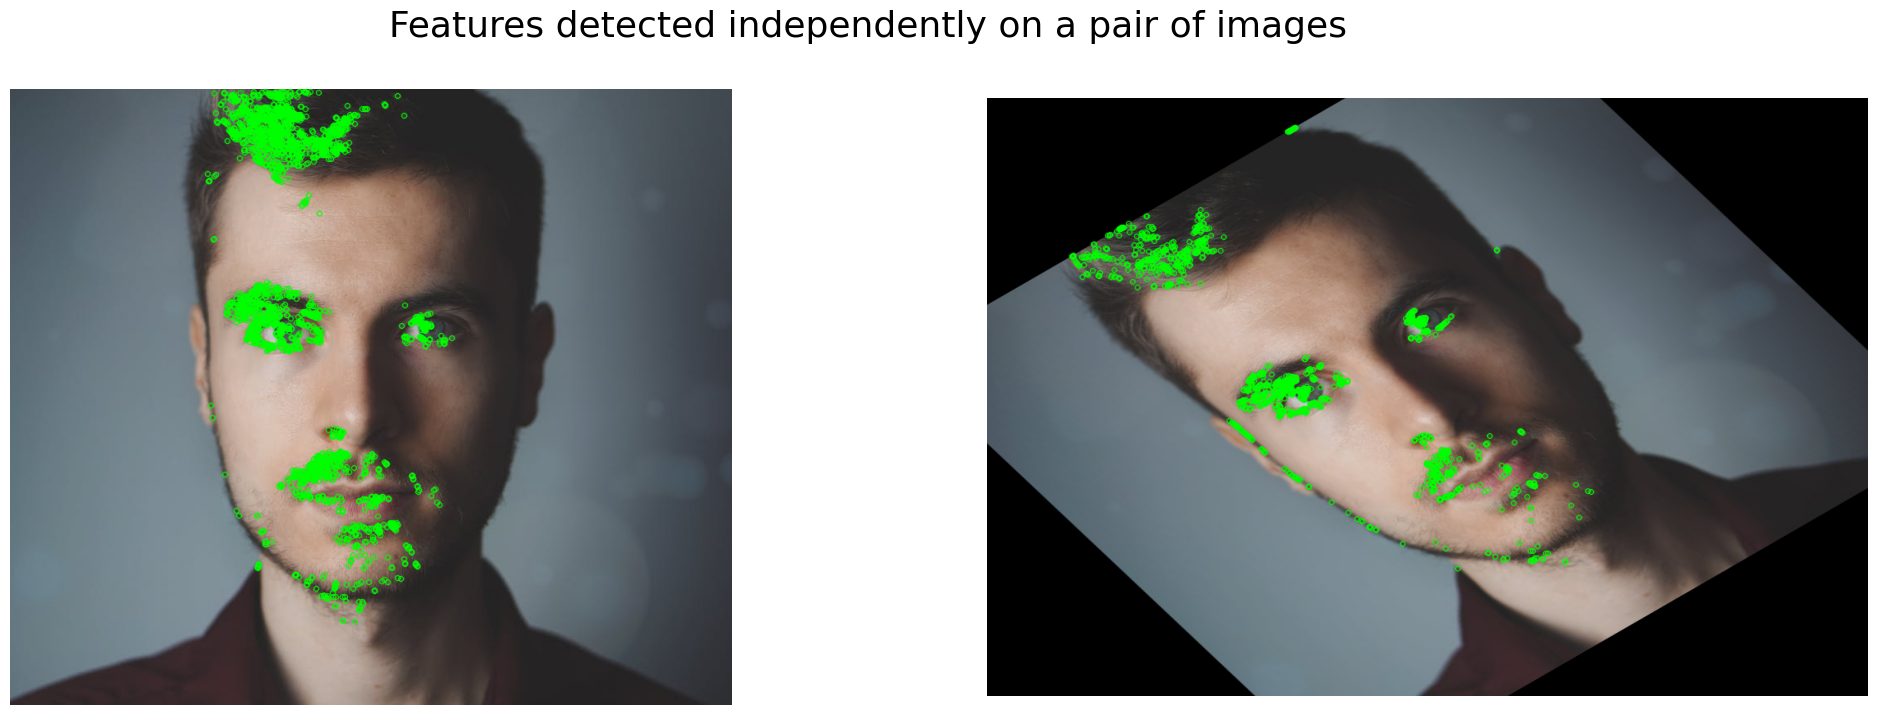

In [65]:
import orb

def mask2d_to_cv2kp(mask,kp_size=1):
    cols,rows = np.where(mask)
    return tuple([
        cv2.KeyPoint(float(r),float(c),kp_size) for c,r 
        in zip(list(cols),list(rows))
    ])

# Visualize the first mask
treshold = 20
border = 3

first_mask1 = orb.get_first_test_mask(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(int), threshold=treshold, border=border)
first_mask2 = orb.get_first_test_mask(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(int), threshold=treshold, border=border)
kp0_1 = mask2d_to_cv2kp(first_mask1)
kp0_2 = mask2d_to_cv2kp(first_mask2)

# # Visualize the results
img1kp = cv2.drawKeypoints(img1, kp0_1, None, color=(0, 255, 0))
img2kp = cv2.drawKeypoints(img2, kp0_2, None, color=(0, 255, 0))
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
axs[0].imshow(cv2.cvtColor(img1kp, cv2.COLOR_RGB2BGR))
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2kp, cv2.COLOR_RGB2BGR))
axs[1].axis("off")
fig.suptitle("Features detected independently on a pair of images", size=26);

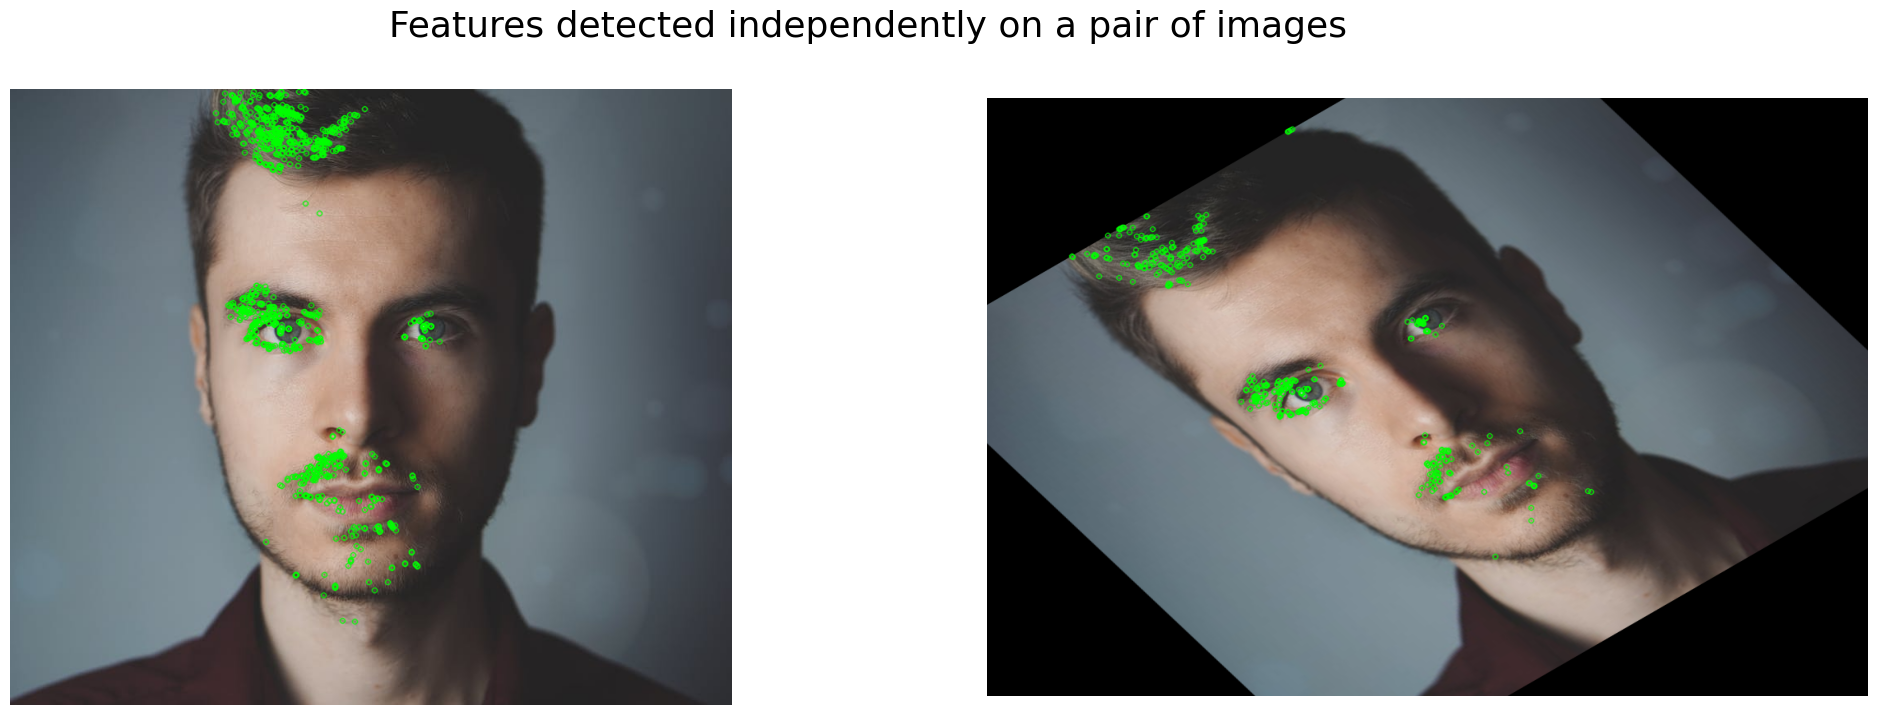

In [66]:
import orb

def mask2d_to_cv2kp(mask,kp_size=1):
    cols,rows = np.where(mask)
    return tuple([
        cv2.KeyPoint(float(r),float(c),kp_size) for c,r 
        in zip(list(cols),list(rows))
    ])

# Visualize the first mask
treshold = 20
border = 3

first_mask1 = orb.get_first_test_mask(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(int), threshold=treshold, border=border)
first_mask2 = orb.get_first_test_mask(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(int), threshold=treshold, border=border)
second_mask1 = orb.get_second_test_mask(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(int), first_test_mask=first_mask1, threshold=treshold)
second_mask2 = orb.get_second_test_mask(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(int), first_test_mask=first_mask2, threshold=treshold)
kp0_1 = mask2d_to_cv2kp(second_mask1)
kp0_2 = mask2d_to_cv2kp(second_mask2)

# # Visualize the results
img1kp = cv2.drawKeypoints(img1, kp0_1, None, color=(0, 255, 0))
img2kp = cv2.drawKeypoints(img2, kp0_2, None, color=(0, 255, 0))
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
axs[0].imshow(cv2.cvtColor(img1kp, cv2.COLOR_RGB2BGR))
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2kp, cv2.COLOR_RGB2BGR))
axs[1].axis("off")
fig.suptitle("Features detected independently on a pair of images", size=26);

### `detect_keypoints()`

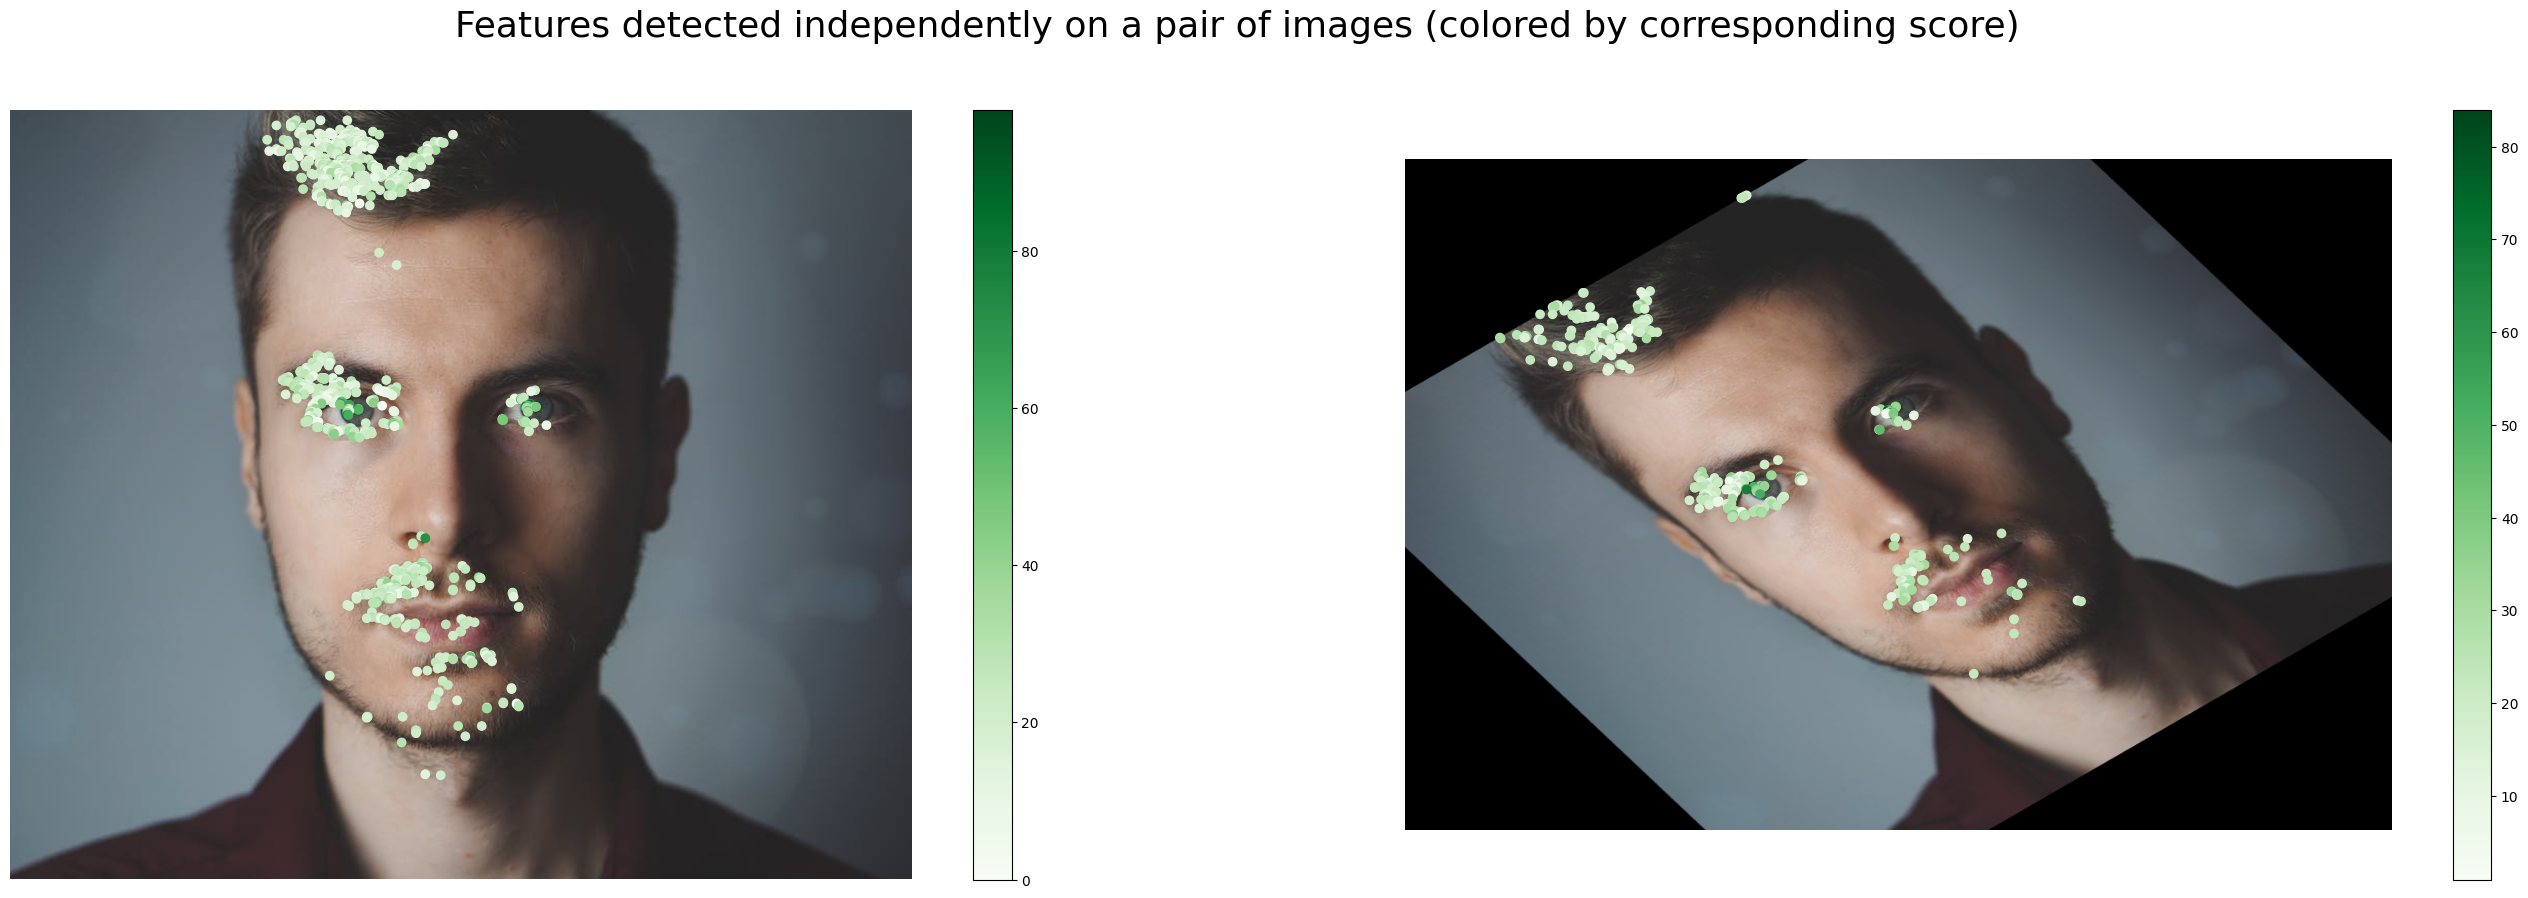

In [67]:
import orb

kp1, scores1 = orb.detect_keypoints(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), threshold=20, border=10)
kp2, scores2 = orb.detect_keypoints(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), threshold=20, border=10)

kp1, kp2 = np.asarray(kp1), np.asarray(kp2)
fig, axs = plt.subplots(1, 2, figsize=(35, 10))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
sc1 = axs[0].scatter(kp1[:, 1], kp1[:, 0], c=scores1, cmap="Greens")
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
sc2 = axs[1].scatter(kp2[:, 1], kp2[:, 0], c=scores2, cmap="Greens")
axs[1].axis("off")
plt.colorbar(sc1, ax=axs[0])
plt.colorbar(sc2, ax=axs[1])
fig.suptitle("Features detected independently on a pair of images (colored by corresponding score)", size=26);

<p align="center">
  <img src="img/img_kp_score_ref.jpg">
</p>

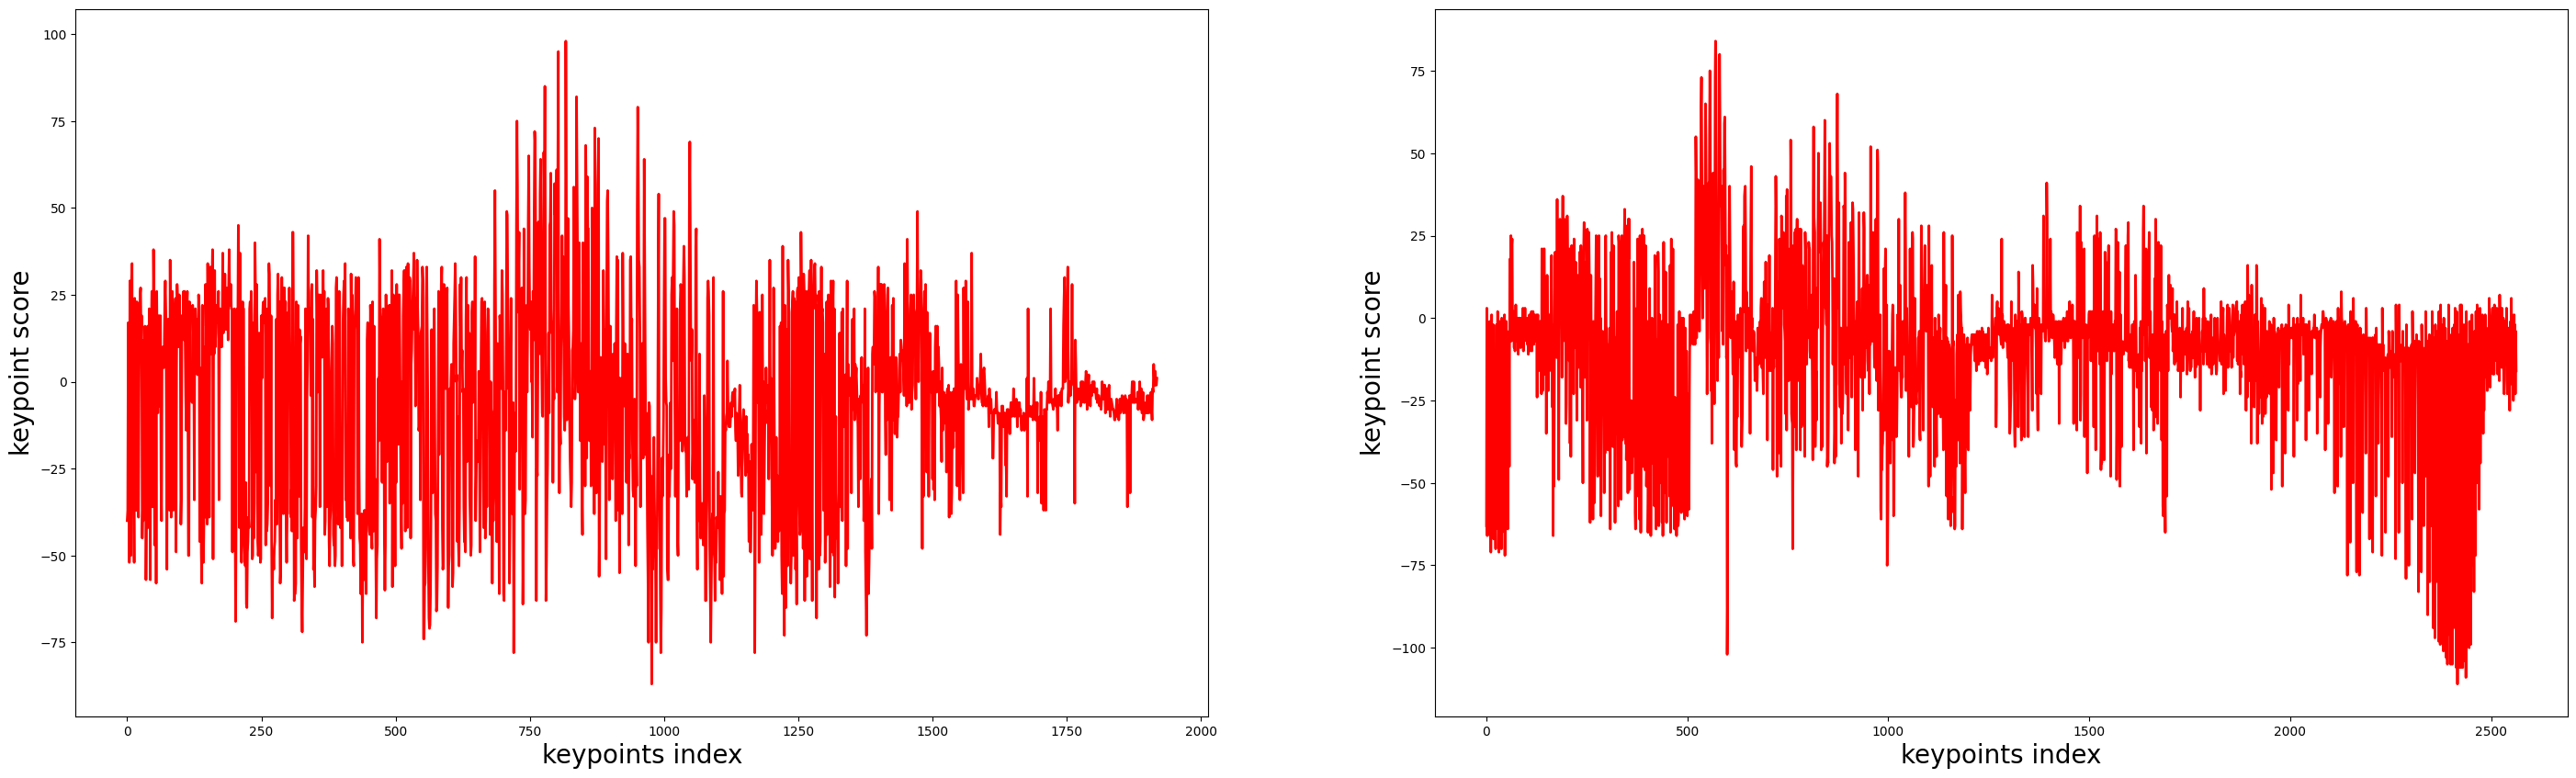

In [52]:
_, axs = plt.subplots(1, 2, figsize=(35, 10))
axs[0].plot(scores1, c="red", linewidth=2.0)
axs[1].plot(scores2, c="red", linewidth=2.0)
for i in [0, 1]:
    axs[i].set_xlabel("keypoints index", fontsize=20)
    axs[i].set_ylabel("keypoint score", fontsize=20)
fig.suptitle("Scores of initial FAST features", size=26);

### `create_pyramid()`

**Note the changed image sizes on the x and y axes!!!**

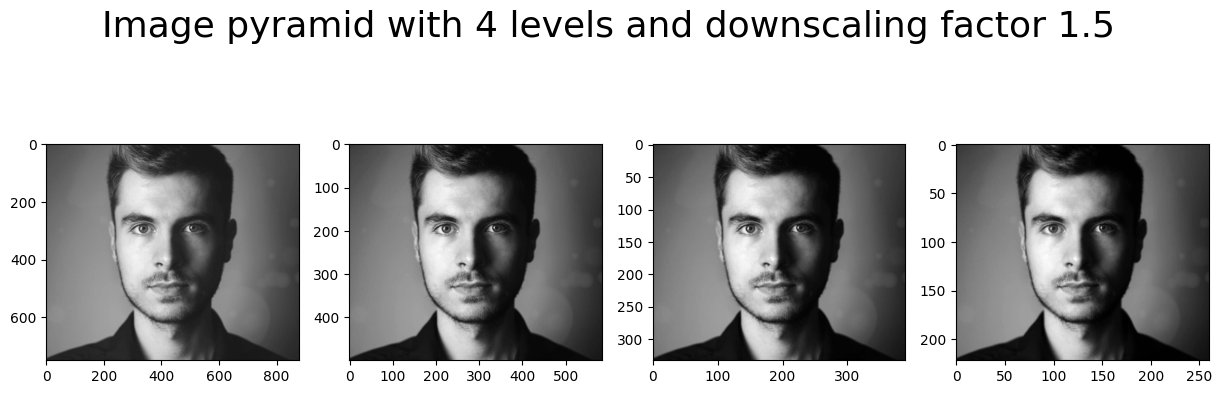

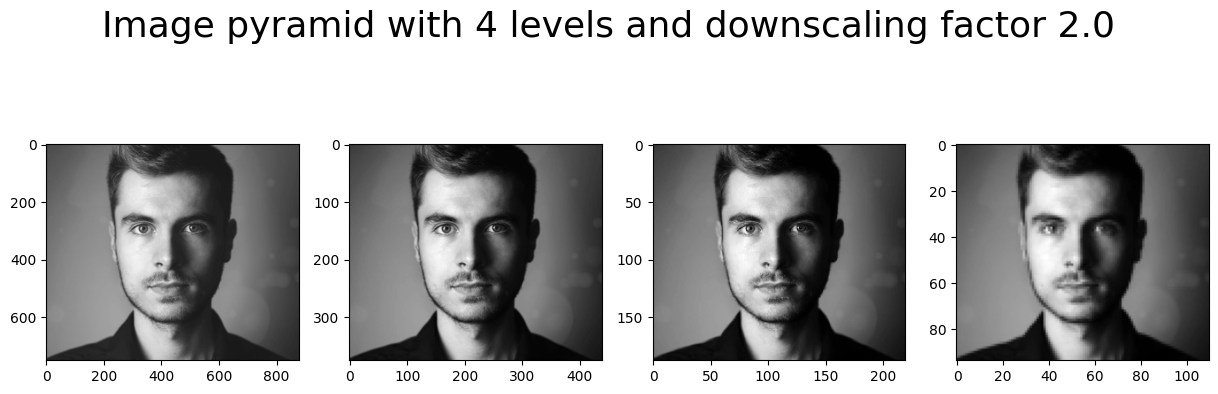

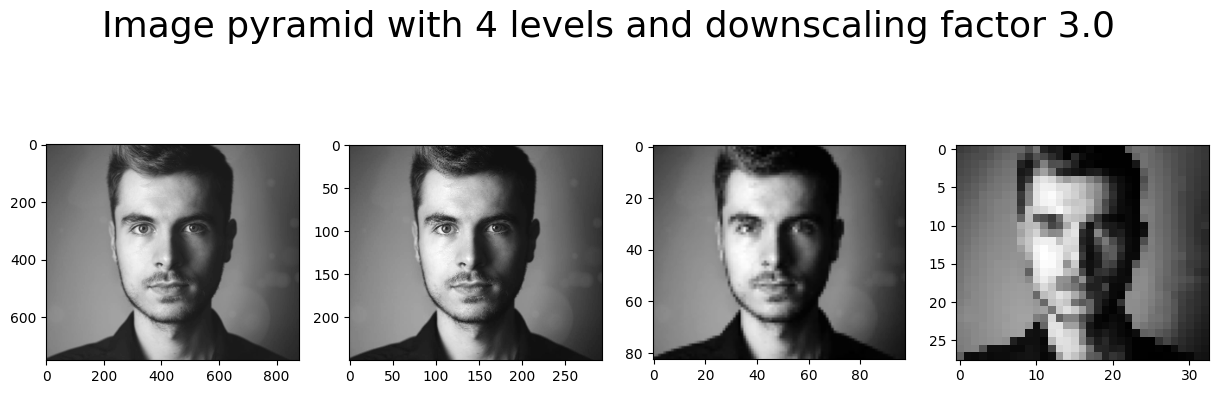

In [87]:
import orb

for downscale_factor in [1.5, 2.0, 3.0]:
    pyr = orb.create_pyramid(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), n_pyr_layers=4, downscale_factor=downscale_factor)
    fig, axs = plt.subplots(1, len(pyr), figsize=(15, 5))
    for i in range(len(pyr)):
        axs[i].imshow(pyr[i], cmap="gray")
        # for tick in axs[i].xaxis.get_major_ticks():
        #     tick.label.set_fontsize(16) 
        #     tick.label.set_rotation('vertical')
        # for tick in axs[i].yaxis.get_major_ticks():
        #     tick.label.set_fontsize(16)
    fig.suptitle(f"Image pyramid with 4 levels and downscaling factor {downscale_factor}", size=26)
    plt.show()


  
pyr = [
    orb.create_pyramid(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), n_pyr_layers=4, downscale_factor=downscale_factor)
    for downscale_factor
    in [1.5, 2.0, 3.0]
]


In [117]:
a = np.matrix([1,2,1])
b = np.matrix([1,0,-1])
a.T@b

matrix([[ 1,  0, -1],
        [ 2,  0, -2],
        [ 1,  0, -1]])

### `get_x_derivative()` and `get_y_derivative()`

<p align="center">
  <img src="img/sobel.png">
</p>

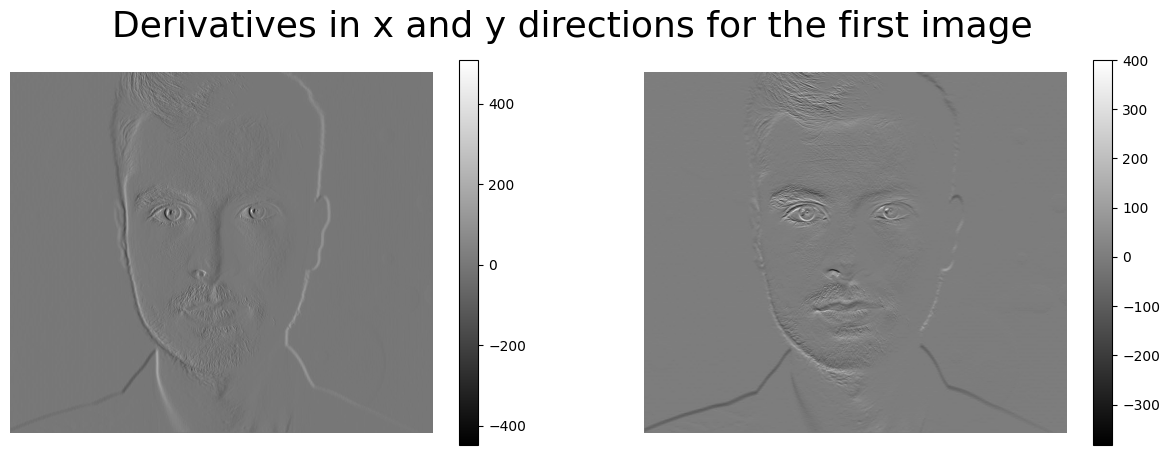

In [124]:
import orb

dx = orb.get_x_derivative(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY))
dy = orb.get_y_derivative(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
im1 = axs[0].imshow(dx, cmap="gray")
axs[0].axis("off")
im2 = axs[1].imshow(dy, cmap="gray")
axs[1].axis("off")
plt.colorbar(im1, ax=axs[0])
plt.colorbar(im2, ax=axs[1])
fig.suptitle("Derivatives in x and y directions for the first image", size=26);


Correct results:
<p align="center">
  <img src="img/img_x_y_derivative.jpg"><br>
</p>

### `get_harris_response()`

<p align="center">
  <img src="img/structure_tensor.png">
</p>

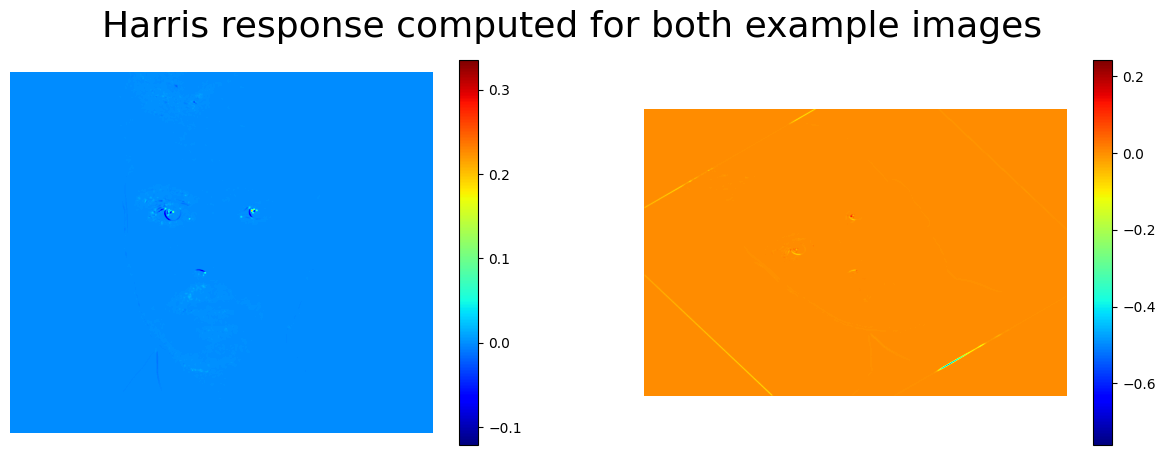

In [129]:
import orb

harris1 = orb.get_harris_response(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY))
harris2 = orb.get_harris_response(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
im1 = axs[0].imshow(harris1, cmap="jet")
axs[0].axis("off")
im2 = axs[1].imshow(harris2, cmap="jet")
axs[1].axis("off")
plt.colorbar(im1, ax=axs[0])
plt.colorbar(im2, ax=axs[1])
fig.suptitle("Harris response computed for both example images", size=26);

### `filter_keypoints()`

ValueError: too many values to unpack (expected 2)

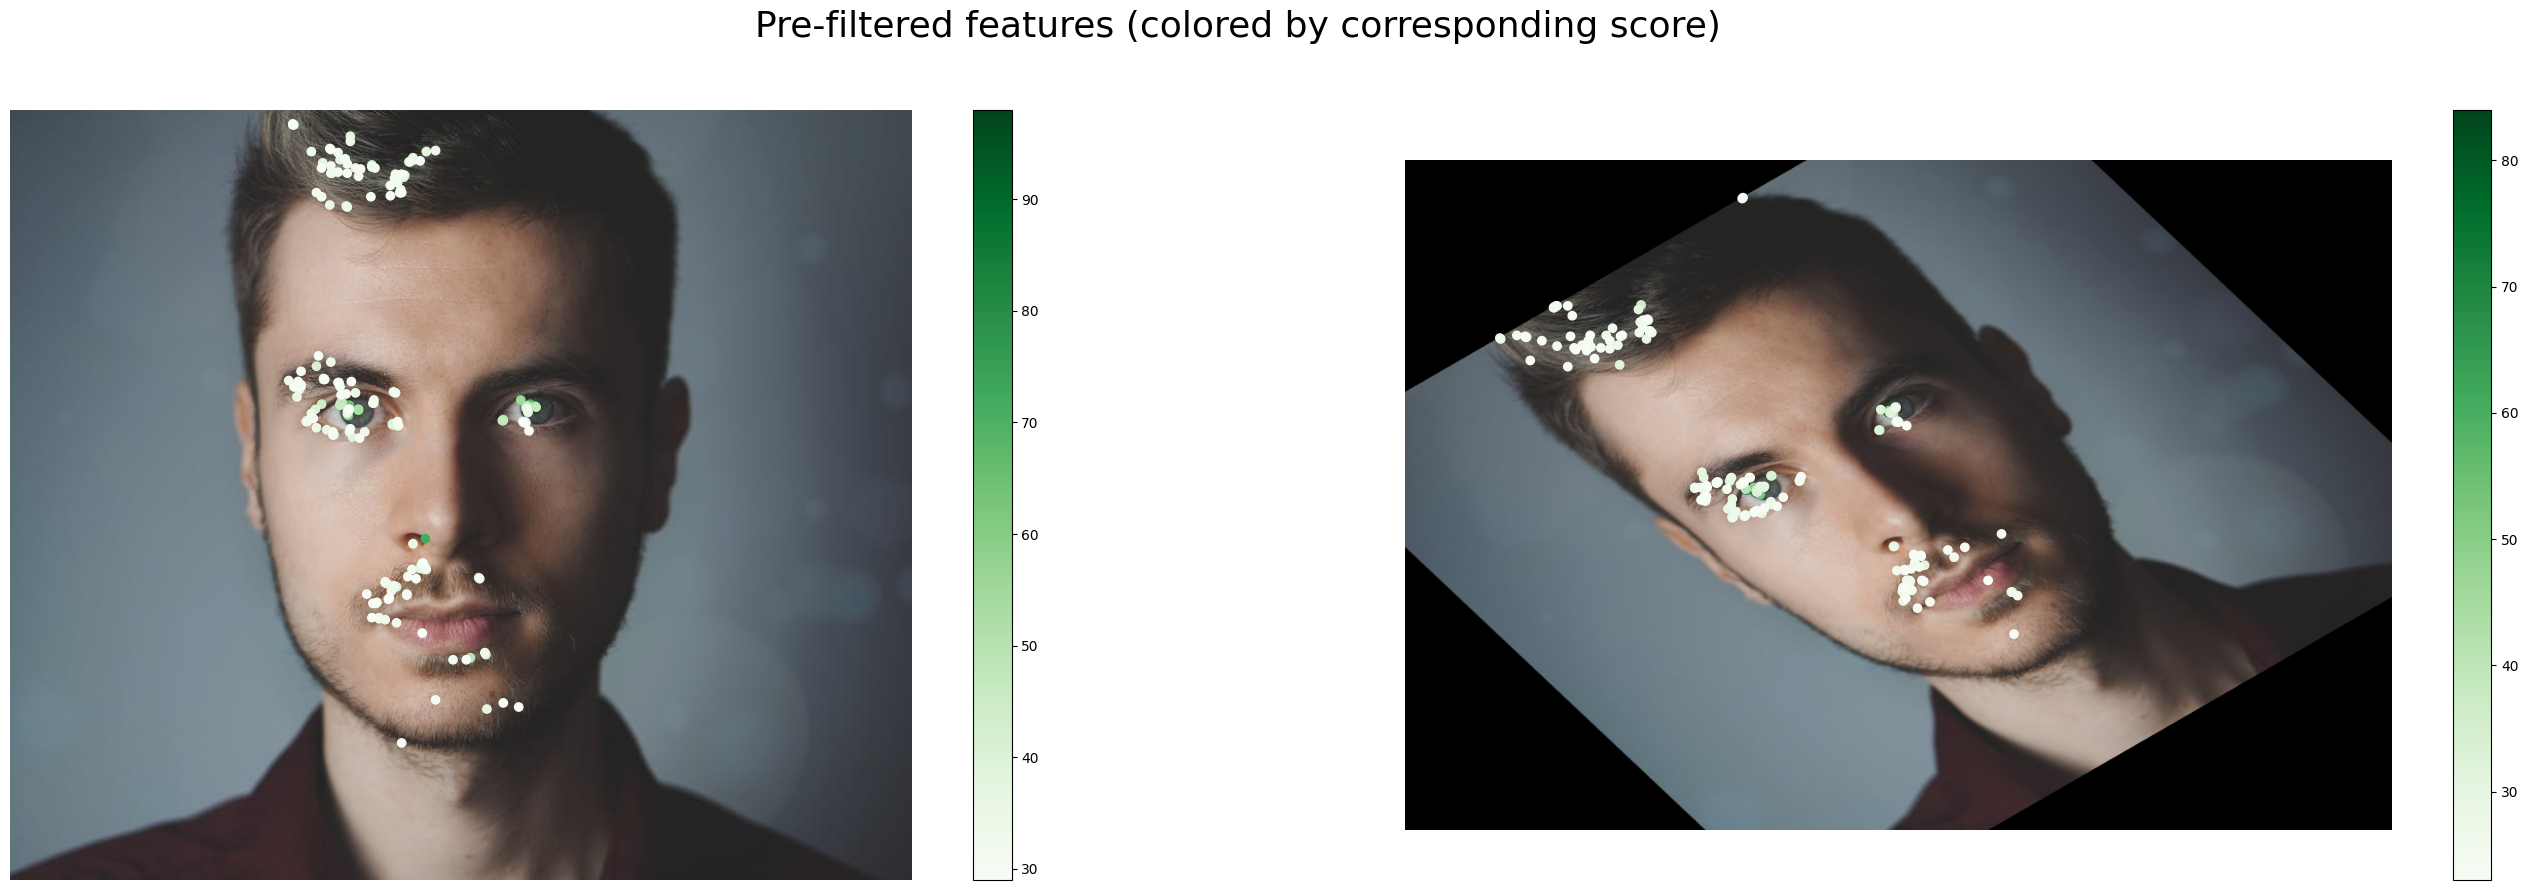

In [135]:
import orb

gray1, gray2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
kp1, scores1 = orb.detect_keypoints(gray1, threshold=20, border=10)
kp2, scores2 = orb.detect_keypoints(gray2, threshold=20, border=10)
n_max_level = 100
kp1, kp2 = np.asarray(kp1), np.asarray(kp2)

# Some pre-filtering by score: already implemented for you in orb.fast()
idxs1, idxs2 = np.argsort(scores1)[::-1], np.argsort(scores2)[::-1]
kp1 = kp1[idxs1][: 2 * n_max_level]
kp2 = kp2[idxs2][: 2 * n_max_level]
scores1 = np.asarray(scores1)[idxs1][: 2 * n_max_level]
scores2 = np.asarray(scores2)[idxs2][: 2 * n_max_level]

fig, axs = plt.subplots(1, 2, figsize=(35, 10))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
sc1 = axs[0].scatter(kp1[:, 1], kp1[:, 0], c=scores1, cmap="Greens")
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
sc2 = axs[1].scatter(kp2[:, 1], kp2[:, 0], c=scores2, cmap="Greens")
axs[1].axis("off")
plt.colorbar(sc1, ax=axs[0])
plt.colorbar(sc2, ax=axs[1])
fig.suptitle("Pre-filtered features (colored by corresponding score)", size=26);

kp1 = orb.filter_keypoints(gray1, kp1.tolist(), n_max_level)
kp2 = orb.filter_keypoints(gray2, kp2.tolist(), n_max_level)
harris1, harris2 = orb.get_harris_response(gray1), orb.get_harris_response(gray2)
kp1_responses = [harris1[row_idx, col_idx] for row_idx, col_idx in kp1][:len(kp1)]
kp2_responses = [harris2[row_idx, col_idx] for row_idx, col_idx in kp2][:len(kp2)]
kp1, kp2 = np.asarray(kp1), np.asarray(kp2)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
sc1 = axs[0].scatter(kp1[:, 1], kp1[:, 0], c=kp1_responses, cmap="Reds")
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
sc2 = axs[1].scatter(kp2[:, 1], kp2[:, 0], c=kp2_responses, cmap="Reds")
axs[1].axis("off")
plt.colorbar(sc1, ax=axs[0])
plt.colorbar(sc2, ax=axs[1])
fig.suptitle("Features filtered by the Harris responses (colored by Harris response)", size=26);

Correct results
<p align="center">
  <img src="img/img_filtered_kp_score_ref.jpg"><br>
  <img src="img/img_filtered_kp_hresp_ref.jpg"><br>
</p>

### `fast()`

(Already implemented for you in `orb.py`.)

In [ ]:
import orb

gray1, gray2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
kp1, kp2 = orb.fast(gray1), orb.fast(gray2)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
colors = cm.get_cmap('Reds')(np.linspace(0, 1, len(kp1)))
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
for level, (kp1_level, kp2_level) in enumerate(zip(kp1, kp2)):
    kp1_level, kp2_level = np.asarray(kp1_level), np.asarray(kp2_level)
    axs[0].scatter(kp1_level[:, 1], kp1_level[:, 0], color=colors[level], alpha=0.5)
    axs[1].scatter(kp2_level[:, 1], kp2_level[:, 0], color=colors[level], alpha=0.5)
axs[0].axis("off")
axs[1].axis("off")
fig.suptitle("Features filtered by the Harris responses (colored by pyramid level)", size=26);